In [1304]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import geopandas
import geoplot
from shapely.geometry import Polygon, Point
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

# define path and variables

In [833]:
path = 'C:/Users/Zaca/Documents/Datasets/nyc/'

# defining functions

In [834]:
pcints = geopandas.read_file(path + 'nypd_precincts.shp').to_crs(epsg=4326)
pcints['pct'] = pcints['pct'].astype('int32')

clean_map = geopandas.GeoDataFrame()
clean_map['precinct'] = pcints['pct'].unique()
clean_map['geometry'] = [Polygon(max(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union, key=lambda a: a.area).exterior) if pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.geom_type == 'MultiPolygon' else Polygon(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.exterior) for pct in clean_map.precinct]

In [841]:
crime = pd.read_csv(path + 'nypd_historic_07-18.csv', index_col=0)

# select type of crime we are analyzing

In [1327]:
desc = 'BURGLARY'
ds = crime[crime.description == desc]

crime.description.value_counts()[:50]

PETIT LARCENY                           984505
HARRASSMENT 2                           733522
ASSAULT 3 & RELATED OFFENSES            623550
CRIMINAL MISCHIEF & RELATED OF          594719
GRAND LARCENY                           505759
DANGEROUS DRUGS                         369783
OFF. AGNST PUB ORD SENSBLTY &           310818
FELONY ASSAULT                          227046
ROBBERY                                 216401
BURGLARY                                203927
MISCELLANEOUS PENAL LAW                 148146
DANGEROUS WEAPONS                       138989
OFFENSES AGAINST PUBLIC ADMINI          118389
GRAND LARCENY OF MOTOR VEHICLE          103253
INTOXICATED & IMPAIRED DRIVING           82341
VEHICLE AND TRAFFIC LAWS                 72680
CRIMINAL TRESPASS                        69732
SEX CRIMES                               66807
THEFT-FRAUD                              61160
FORGERY                                  58875
FRAUDS                                   37152
POSSESSION OF

In [843]:
# transform to datetime
ds['date'] = pd.to_datetime(ds['date'])

C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# space and time selection

In [1254]:
start_date = '2017-09-01'
end_date = '2018-01-01'
precinct = 114

In [1255]:
subselection = ds[(ds.date > start_date) & (ds.date < end_date) & (ds.precinct == precinct)]

In [1256]:
locations = subselection[['latitude', 'longitude', 'time']]

In [1257]:
stdscaler = StandardScaler()
features = stdscaler.fit_transform(locations)

In [1306]:
n_clusters = 4
cluster = KMeans(n_clusters=n_clusters, random_state=0, n_jobs=-1)

cluster = AgglomerativeClustering(n_clusters=4)
# Train model
model = cluster.fit(features)

In [1307]:
subselection['k_clusters'] = model.labels_

C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1308]:
subselection.k_clusters.value_counts().reset_index()

,index,k_clusters
0,0,40
1,2,24
2,1,16
3,3,11


In [1309]:
region = geopandas.read_file(path + 'nypd_precincts.shp').to_crs(epsg=4326)

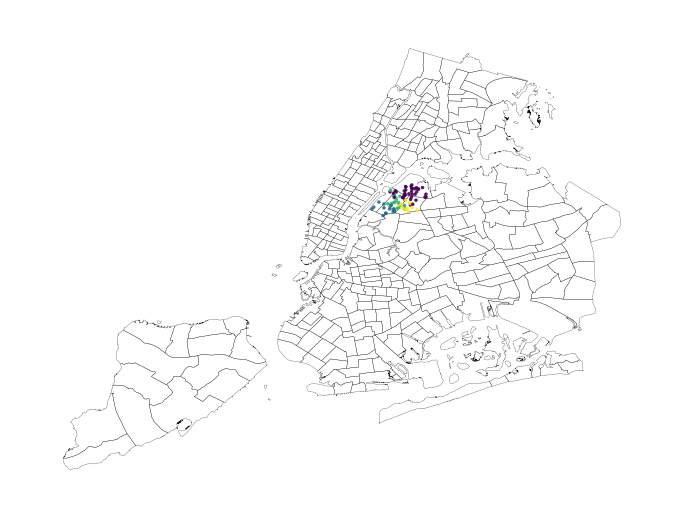

In [1310]:
ax = geoplot.polyplot(region, figsize=(12, 12), lw= .25, facecolor= 'none', edgecolor='k', alpha=1);
ax.scatter(subselection['longitude'], subselection['latitude'], c=subselection['k_clusters'], alpha=.9, cmap='viridis', s=10)

In [1311]:
subselection.groupby('k_clusters').count()

,date,time,precinct,class_code,description,level,borough,premises,latitude,longitude,dow
k_clusters,,,,,,,,,,,
0,40,40,40,40,40,40,40,40,40,40,40
1,16,16,16,16,16,16,16,16,16,16,16
2,24,24,24,24,24,24,24,24,24,24,24
3,11,11,11,11,11,11,11,11,11,11,11


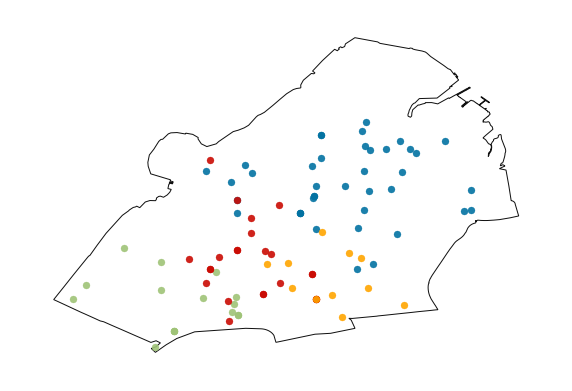

In [1312]:
ax = geoplot.polyplot(clean_map[clean_map.precinct == precinct], figsize=(10, 10), lw= 1, facecolor= 'none', edgecolor='k', alpha=1)

ax.scatter(subselection[subselection['k_clusters'] == 0]['longitude'], subselection[subselection['k_clusters'] == 0]['latitude'], c='b', alpha=.9)
ax.scatter(subselection[subselection['k_clusters'] == 1]['longitude'], subselection[subselection['k_clusters'] == 1]['latitude'], c='g', alpha=.9)
ax.scatter(subselection[subselection['k_clusters'] == 2]['longitude'], subselection[subselection['k_clusters'] == 2]['latitude'], c='r', alpha=.9)
ax.scatter(subselection[subselection['k_clusters'] == 3]['longitude'], subselection[subselection['k_clusters'] == 3]['latitude'], c='orange', alpha=.9);

(0, 24)

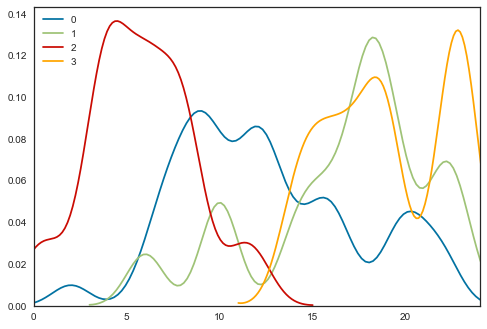

In [1313]:
sns.kdeplot(subselection[subselection.k_clusters == 0].time, bw=1, color='b', label='0')
sns.kdeplot(subselection[subselection.k_clusters == 1].time, bw=1, color='g', label='1')
sns.kdeplot(subselection[subselection.k_clusters == 2].time, bw=1, color='r', label='2')
sns.kdeplot(subselection[subselection.k_clusters == 3].time, bw=1, color='orange', label='3')

plt.xlim(0, 24)

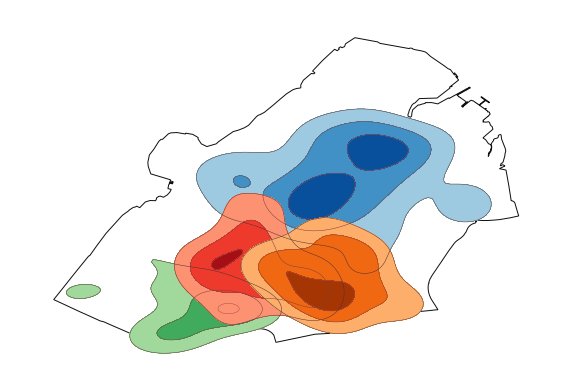

In [1314]:
ax = geoplot.polyplot(clean_map[clean_map.precinct == precinct], figsize=(10, 10), lw= 1, facecolor= 'none', edgecolor='k', alpha=1)

bw = 'scott'
levels = 3

sns.kdeplot(subselection[subselection['k_clusters'] == 0]['longitude'], subselection[subselection['k_clusters'] == 0]['latitude'], shade=True, shade_lowest=False, cmap='Blues', levels=levels, bw=bw)
sns.kdeplot(subselection[subselection['k_clusters'] == 0]['longitude'], subselection[subselection['k_clusters'] == 0]['latitude'], linewidths=.5, levels=levels, bw=bw)


sns.kdeplot(subselection[subselection['k_clusters'] == 1]['longitude'], subselection[subselection['k_clusters'] == 1]['latitude'], shade=True, shade_lowest=False, cmap='Greens', levels=levels, bw=bw)
sns.kdeplot(subselection[subselection['k_clusters'] == 1]['longitude'], subselection[subselection['k_clusters'] == 1]['latitude'], linewidths=.5, levels=levels, bw=bw)


sns.kdeplot(subselection[subselection['k_clusters'] == 2]['longitude'], subselection[subselection['k_clusters'] == 2]['latitude'], shade=True, shade_lowest=False, cmap='Reds', levels=levels, bw=bw)
sns.kdeplot(subselection[subselection['k_clusters'] == 2]['longitude'], subselection[subselection['k_clusters'] == 2]['latitude'], linewidths=.5, levels=levels, bw=bw)


sns.kdeplot(subselection[subselection['k_clusters'] == 3]['longitude'], subselection[subselection['k_clusters'] == 3]['latitude'], shade=True, shade_lowest=False, cmap='Oranges', levels=levels, bw=bw)
sns.kdeplot(subselection[subselection['k_clusters'] == 3]['longitude'], subselection[subselection['k_clusters'] == 3]['latitude'], linewidths=.5, levels=levels, bw=bw)

In [1324]:
def make_contour(longitude, latitude, precinct_polygon, colors):
    
    x = longitude
    y = latitude
    
    nlevels=2
    
    xmin = precinct_polygon.bounds['minx'].values
    xmax = precinct_polygon.bounds['maxx'].values
    ymin = precinct_polygon.bounds['miny'].values
    ymax = precinct_polygon.bounds['maxy'].values
    
    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    cset = ax.contour(xx, yy, f, colors=colors, levels=nlevels)
    #cfset = ax.contourf(xx, yy, f, cmap='plasma')
    
    return cset


def get_level(contour, n):
    
    # the n gives you the level
    # just remember that its backwards
    # the outermost level is 0
    
    x = []
    y = []
    for j in range(len(contour.allsegs)):
        for ii, seg in enumerate(contour.allsegs[j]):
            x += [seg[:,0]]
            y += [seg[:,1]]
    
    return list(zip(x[n], y[n]))  


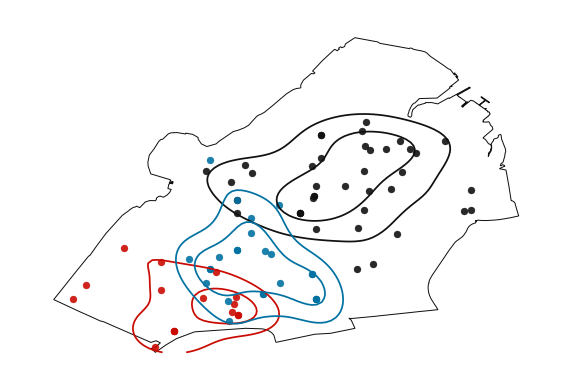

In [1325]:
ax = geoplot.polyplot(clean_map[clean_map.precinct == precinct], figsize=(10, 10), lw= 1, facecolor= 'none', edgecolor='k', alpha=1)

c0 = make_contour(subselection[subselection['k_clusters'] == 0]['longitude'], subselection[subselection['k_clusters'] == 0]['latitude'], clean_map[clean_map.precinct == precinct]['geometry'], colors='k')
ax.scatter(subselection[subselection['k_clusters'] == 0]['longitude'], subselection[subselection['k_clusters'] == 0]['latitude'], c='k', alpha=.9)

c1 = make_contour(subselection[subselection['k_clusters'] == 1]['longitude'], subselection[subselection['k_clusters'] == 1]['latitude'], clean_map[clean_map.precinct == precinct]['geometry'], colors='r')
ax.scatter(subselection[subselection['k_clusters'] == 1]['longitude'], subselection[subselection['k_clusters'] == 1]['latitude'], c='r', alpha=.9)

c2 = make_contour(subselection[subselection['k_clusters'] == 2]['longitude'], subselection[subselection['k_clusters'] == 2]['latitude'], clean_map[clean_map.precinct == precinct]['geometry'], colors='b')
ax.scatter(subselection[subselection['k_clusters'] == 2]['longitude'], subselection[subselection['k_clusters'] == 2]['latitude'], c='b', alpha=.9)

(0, 24)

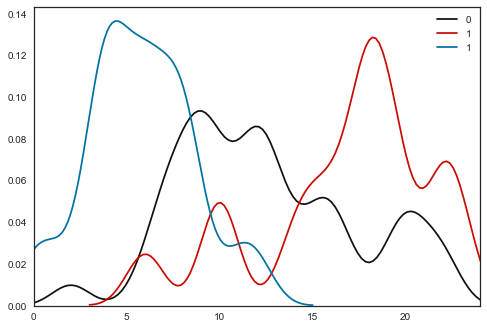

In [1322]:
# show time distributions for these 2 clusters
sns.kdeplot(subselection[subselection.k_clusters == 0].time, bw=1, color='k', label='0')
sns.kdeplot(subselection[subselection.k_clusters == 1].time, bw=1, color='r', label='1')
sns.kdeplot(subselection[subselection.k_clusters == 2].time, bw=1, color='b', label='1')
plt.xlim(0, 24)

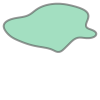

In [1318]:
# get ROI
c0_roi = Polygon(get_level(c0, 0))
c1_roi = Polygon(get_level(c1, 0))

c0_roi

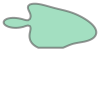

In [1319]:
c1_roi

In [1323]:
# get time window
subselection[subselection.k_clusters == 0].time.describe()

count    40.000000
mean     12.550000
std       4.872476
min       2.000000
25%       9.000000
50%      12.000000
75%      16.000000
max      22.000000
Name: time, dtype: float64

In [ ]:
# Calculating median in KDEPLOT

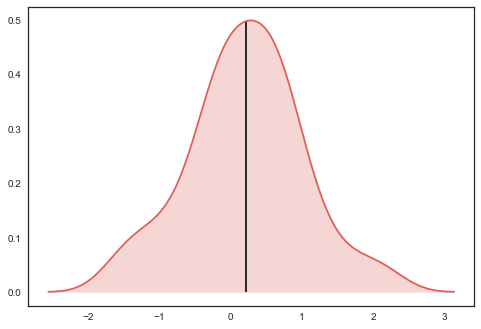

In [1272]:
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette("hls", 1)
data = np.random.randn(30)
p=sns.kdeplot(data, shade=True)

x,y = p.get_lines()[0].get_data()

#care with the order, it is first y
#initial fills a 0 so the result has same length than x
cdf = scipy.integrate.cumtrapz(y, x, initial=0)

nearest_05 = np.abs(cdf-0.5).argmin()

x_median = x[nearest_05]
y_median = y[nearest_05]

plt.vlines(x_median, 0, y_median)
plt.show()